<div >
    <img src = "../banner/banner_ML_UNLP_1900_200.png" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/ML_UNLP_Lectures/blob/main/Week04/Notebook_SS04_clasification.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# Classification

To work through the steps of probability-based classification, we’ll use a real dataset on loans and credit from a set of local lenders in Germany (taken from the UC Irvine Machine Learning Repository and cleaned for our purposes). 

Credit scoring is a classic problem of classification, and it remains one of the big application domains for ML: use previous loan results (default versus payment) to train a model that can predict the performance of potential new loans.

\begin{align}
Default=f(x) + u
\end{align}

where $Default=I(Default=1)$



# Dataset

Let's load the modules:

In [1]:
import numpy as np
import pandas as pd

In [2]:
db = pd.read_csv("https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/credit.csv")
db.head()

,Unnamed: 0,Default,duration,amount,installment,age,history,purpose,foreign,rent
0,1,0,6,1169,4,67,terrible,goods/repair,foreign,False
1,2,1,48,5951,2,22,poor,goods/repair,foreign,False
2,3,0,12,2096,2,49,terrible,edu,foreign,False
3,4,0,42,7882,2,45,poor,goods/repair,foreign,False
4,5,1,24,4870,3,53,poor,newcar,foreign,False


In [3]:
db = db.iloc[:, 1:] #remove first column
db.head()

,Default,duration,amount,installment,age,history,purpose,foreign,rent
0,0,6,1169,4,67,terrible,goods/repair,foreign,False
1,1,48,5951,2,22,poor,goods/repair,foreign,False
2,0,12,2096,2,49,terrible,edu,foreign,False
3,0,42,7882,2,45,poor,goods/repair,foreign,False
4,1,24,4870,3,53,poor,newcar,foreign,False


In [4]:
db['Default'].value_counts(normalize=True) * 100

0    70.0
1    30.0
Name: Default, dtype: float64

In [5]:
db['foreign'].value_counts(normalize=True) * 100


foreign    96.3
german      3.7
Name: foreign, dtype: float64

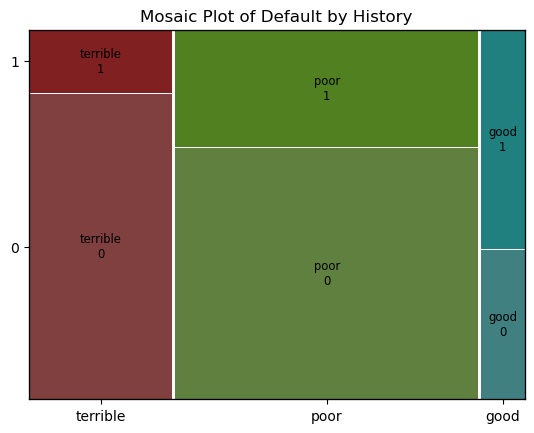

In [6]:
import matplotlib.pyplot as plt
from statsmodels.graphics.mosaicplot import mosaic

# Assuming df is your DataFrame equivalent to the 'credit' data frame in R
# and it contains 'Default' and 'history' columns

# Create a mosaic plot
mosaic(db, ['history', 'Default'], title='Mosaic Plot of Default by History')
plt.ylabel('Default')
plt.show()


## Estimación Logit

\begin{align}
p_i &=\frac{e^{X_i\beta}}{1+e^{X_i\beta}}
\end{align}


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split



# Convert 'history' and 'purpose' into dummy variables
db_dummies = pd.get_dummies(db, columns=['history', 'purpose','foreign'], drop_first=True)

# Separate the independent and dependent variables
X = db_dummies.drop('Default', axis=1)
y = db_dummies['Default']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )




In [ ]:
# Fit the logistic regression model
logit_model = LogisticRegression(max_iter=200 )
logit_model.fit(X_train,y_train)


## Prediction


\begin{align}
\hat{p}_i &=\frac{e^{X_i\hat{\beta}}}{1+e^{X_i\hat{\beta}}}
\end{align}

In [ ]:
y_test=pd.DataFrame(y_test)
y_test.head()

In [ ]:
# Predict the probabilities
y_test['prob_hat'] = logit_model.predict_proba(X_test)[:, 1]

# Display the first few rows of the specified columns
y_test.head(30)


# CARTs

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Creación del modelo
# ------------------------------------------------------------------------------
model_tree = DecisionTreeClassifier(
            max_depth         = 5,
            criterion         = 'gini',
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
model_tree.fit(X_train, y_train)



In [ ]:
from sklearn.tree import plot_tree

# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(13, 6))

print(f"Profundidad del árbol: {model_tree.get_depth()}")
print(f"Número de nodos terminales: {model_tree.get_n_leaves()}")

plot = plot_tree(
            decision_tree = model_tree,
            feature_names = X_train.columns,
            class_names   = 'ventas_altas',
            filled        = True,
            impurity      = False,
            fontsize      = 7,
            ax            = ax
       )



In [ ]:

# Predict the probabilities
y_test['prob_hat_tree'] = model_tree.predict_proba(X_test)[:, 1]

# Display the first few rows of the specified columns
y_test.head()


### Pruning

In [ ]:
from sklearn.model_selection import GridSearchCV

# Post pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(0, 0.005, 40)}
param_grid

In [ ]:
from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(f1_score)



# Búsqueda por validación cruzada
grid_tree = GridSearchCV(
        # El árbol se crece al máximo posible antes de aplicar el pruning
        estimator = DecisionTreeClassifier(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123
                       ),
        param_grid = param_grid,
        scoring    = f1_scorer,
        cv         = 5,
        refit      = True,
        return_train_score = True
      )

grid_tree.fit(X_train, y_train)


In [ ]:
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid_tree.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");


In [ ]:
grid_tree.best_params_

In [ ]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
model_tree_final = grid_tree.best_estimator_
print(f"Profundidad del árbol: {model_tree_final.get_depth()}")
print(f"Número de nodos terminales: {model_tree_final.get_n_leaves()}")

In [ ]:

# Predict the probabilities
y_test['prob_hat_tree_cp'] = model_tree_final.predict_proba(X_test)[:, 1]

# Display the first few rows of the specified columns
y_test.head()


## Random Forests

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
import multiprocessing

In [ ]:


# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {
    'n_estimators': [150,200], #número de árboles
    'max_features': [5, 7, 9], # número de predictores
    'max_depth'   : [None, 3, 10, 20], #profundidad
    'criterion'   : ['gini', 'entropy'] # uno puede usar gini o entropia
}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid_forest = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid_forest.fit(X = X_train, y = y_train)



In [ ]:

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_forest.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)


In [ ]:


# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid_forest.best_params_, ":", grid_forest.best_score_, grid_forest.scoring)



In [ ]:


model_grid_forest_final = grid_forest.best_estimator_

# Predict the probabilities
y_test['prob_hat_forest'] = model_grid_forest_final.predict_proba(X_test)[:, 1]

# Display the first few rows of the specified columns
y_test.head()


## Importancia de predictores
### Importancia por pureza de nodos

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importancia': model_grid_forest_final.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

###  Importancia por permutación

In [ ]:
from sklearn.inspection import permutation_importance

importancia = permutation_importance(
                estimator    = model_grid_forest_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'accuracy',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)



# AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
model_ada= AdaBoostClassifier(
                DecisionTreeClassifier(max_depth=1), #clasificador G(X)
                                      n_estimators=300 # número de iteraciones
)

In [ ]:
# Entrenamiento del modelo
# ------------------------------------------------------------------------------
model_ada.fit(X_train, y_train)

In [ ]:
# Predict the probabilities
y_test['prob_hat_ada'] = model_ada.predict_proba(X_test)[:, 1]

# Display the first few rows of the specified columns
y_test.head()


# Classification and Missclasification



\begin{align}
\hat{Y}_i= 1[\hat{p}_i >0.5]
\end{align}

In [ ]:

# Define the rule (threshold)
rule = 0.5

# Create the predicted class labels based on the rule
y_test['Default_hat_logit'] = (y_test['prob_hat'] > rule).astype(int)

# Display the first few rows of the specified columns
y_test[['Default', 'prob_hat', 'Default_hat_logit']].head(30)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(
            y_true    = y_test['Default'],
            y_pred    = y_test['Default_hat_logit'],
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test['Default'],
    y_test['Default_hat_logit'],
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix



## Trees

In [ ]:

# Create the predicted class labels based on the rule
y_test['Default_hat_tree'] = (y_test['prob_hat_tree'] > rule).astype(int)


In [ ]:

accuracy = accuracy_score(
            y_true    = y_test['Default'],
            y_pred    = y_test['Default_hat_tree'],
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")



In [ ]:

# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test['Default'],
    y_test['Default_hat_tree'],
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix

## Trees CP

In [ ]:

# Create the predicted class labels based on the rule
y_test['Default_hat_tree_cp'] = (y_test['prob_hat_tree_cp'] > rule).astype(int)


In [ ]:

accuracy = accuracy_score(
            y_true    = y_test['Default'],
            y_pred    = y_test['Default_hat_tree_cp'],
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")



In [ ]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test['Default'],
    y_test['Default_hat_tree_cp'],
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix

## Forest

In [ ]:

# Create the predicted class labels based on the rule
y_test['Default_hat_forest'] = (y_test['prob_hat_forest'] > rule).astype(int)


In [ ]:

accuracy = accuracy_score(
            y_true    = y_test['Default'],
            y_pred    = y_test['Default_hat_forest'],
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")



In [ ]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test['Default'],
    y_test['Default_hat_forest'],
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix

## AdaBoost

In [ ]:

# Create the predicted class labels based on the rule
y_test['Default_hat_ada'] = (y_test['prob_hat_ada'] > rule).astype(int)


In [ ]:

accuracy = accuracy_score(
            y_true    = y_test['Default'],
            y_pred    = y_test['Default_hat_ada'],
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")



In [ ]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test['Default'],
    y_test['Default_hat_ada'],
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix

In [ ]:
from sklearn.metrics import f1_score



# Dictionary to hold F1 scores
f1_scores = {}

f1_scores['Logit'] = f1_score(    y_test['Default'], y_test['Default_hat_logit'])
f1_scores['CART'] = f1_score(    y_test['Default'], y_test['Default_hat_tree'])
f1_scores['CART CP'] = f1_score(    y_test['Default'], y_test['Default_hat_tree_cp'])
f1_scores['Forest'] = f1_score(    y_test['Default'], y_test['Default_hat_forest'])
f1_scores['AdaBoost'] = f1_score(    y_test['Default'], y_test['Default_hat_ada'])


In [ ]:
f1_df = pd.DataFrame(list(f1_scores.items()), columns=['Model', 'F1 Score'])
print(f1_df)

In [ ]:
from sklearn.metrics import roc_curve, auc


models = {
    'Logit': logit_model,
    'CART': model_tree,
    'CART CP': model_tree_final,
    'Random Forest': model_grid_forest_final,
    'AdaBoost': model_ada
}

auc_scores = {}


In [ ]:

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test['Default'], y_pred_prob)
    roc_auc = auc(fpr, tpr)
    auc_scores[name] = roc_auc

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
# Create DataFrame for AUC scores
auc_df = pd.DataFrame(list(auc_scores.items()), columns=['Model', 'AUC Score'])
auc_df

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test['Default'], y_test['prob_hat'])

# Calculate the Euclidean distance for each point on the ROC curve from the top-left corner
distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)

# Find the optimal threshold
optimal_idx = np.argmin(distances)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

In [ ]:

plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'bo', label='Optimal Threshold')
plt.fill_between(fpr, tpr, alpha=0.2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:

# Create the predicted class labels based on the rule
y_test['Default_hat_optimal'] = (y_test['prob_hat'] > optimal_threshold).astype(int)


In [ ]:

accuracy = accuracy_score(
            y_true    = y_test['Default'],
            y_pred    = y_test['Default_hat_optimal'],
            normalize = True
           )
print("")
print(f"El accuracy de test es: {100*accuracy}%")



In [ ]:
print(f"El F1 de test es: {100*f1_score(    y_test['Default'], y_test['Default_hat_logit'])}%")

In [ ]:
# Matriz de confusión de las predicciones de test
# ==============================================================================
confusion_matrix = pd.crosstab(
    y_test['Default'],
    y_test['Default_hat_logit'],
    rownames=['Real'],
    colnames=['Predicción']
)
confusion_matrix